# 1. Import Dependencies

In [1]:
!pip install dlib

Defaulting to user installation because normal site-packages is not writeable


# Video processing

In [ ]:
!wget https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat


--2024-10-17 17:21:44--  https://github.com/italojs/facial-landmarks-recognition/raw/master/shape_predictor_68_face_landmarks.dat
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/master/shape_predictor_68_face_landmarks.dat [following]
--2024-10-17 17:21:44--  https://raw.githubusercontent.com/italojs/facial-landmarks-recognition/master/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/octet-stream]
Saving to: 'shape_predictor_68_face_landmarks.dat.1'

shape_predictor_68_ 100%[===================>

In [ ]:
import tensorflow as tf

import numpy as np

import matplotlib.pyplot as plt

import cv2

import imageio

import os

import glob

import string

import dlib

from typing import List


In [ ]:
# Initialize dlib face detector and landmark predictor

detector = dlib.get_frontal_face_detector()

predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")



# Indexes for mouth landmarks (according to the 68 points dlib model)

MOUTH_POINTS = list(range(48, 61))

In [ ]:
def clip_mouth(frame):

    # Convert frame to grayscale for dlib processing

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)



    # Detect faces in the frame

    faces = detector(gray)



    if len(faces) == 0:

        return None  # If no face is detected, return None



    # Process the first face detected

    face = faces[0]

    landmarks = predictor(gray, face)



    # Get the coordinates of the mouth landmarks

    mouth_points = []

    for i in MOUTH_POINTS:

        x = landmarks.part(i).x

        y = landmarks.part(i).y

        mouth_points.append((x, y))



    # Calculate the bounding box around the lips

    x_coords = [pt[0] for pt in mouth_points]

    y_coords = [pt[1] for pt in mouth_points]

    min_x = min(x_coords)

    max_x = max(x_coords)

    min_y = min(y_coords)

    max_y = max(y_coords)



    # Add some padding around the mouth

    padding = 30

    min_x = max(0, min_x - padding)

    max_x = min(frame.shape[1], max_x + padding)

    min_y = max(0, min_y - padding)

    max_y = min(frame.shape[0], max_y + padding)



    # Crop the mouth region from the frame

    mouth_region = frame[min_y:max_y, min_x:max_x]



    return mouth_region

In [ ]:
def load_video(path: str) -> List[float]:

    cap = cv2.VideoCapture(path)

    frames = []



    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):

        ret, frame = cap.read()

        if not ret:

            break



        # Clip the mouth region from the video

        mouth_region = clip_mouth(frame)

        if mouth_region is not None:

            # Resize the clipped mouth region to a fixed size, e.g., 128x64

            mouth_region = cv2.resize(mouth_region, (140, 46), interpolation=cv2.INTER_AREA)

            mouth_region = cv2.cvtColor(mouth_region, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

            mouth_region = tf.expand_dims(mouth_region, axis=-1)  # Add channel dimension (height, width, 1)

            frames.append(mouth_region)



    cap.release()

    frames_tensor = tf.stack(frames)  # Shape: (num_frames, height, width, 1)



    # Normalize the frames

    mean = tf.reduce_mean(frames_tensor)

    std = tf.math.reduce_std(tf.cast(frames_tensor, tf.float32))







    return tf.cast((frames_tensor - mean), tf.float32) / std

# 2. Data Loading Functions

#### Specification of Loading Video and Preprocessing

* Step 1. Read the video file

* Step 2. Crop the frames in approximate location of the lips

* Step 3. Normalize the frames

In [ ]:
frames = load_video("/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s1_processed/bbaf2n.mpg")

print(frames.shape)

(75, 46, 140, 1)


In [ ]:
frames.shape

TensorShape([75, 46, 140, 1])

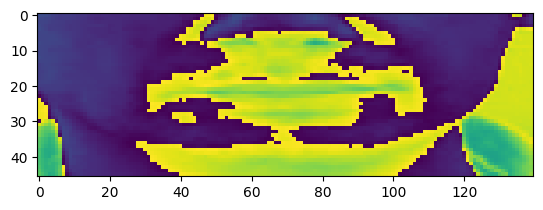

In [ ]:
plt.imshow(frames[3])

### Create Vocabulary and LookUp Table

This lookup table will be used to encode and decoded the characters in labels. This should be consistent over each and every run

In [ ]:
vocab = string.ascii_lowercase + "'?! "

vocab = list(vocab)

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")

num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

In [ ]:
char2num_dict = {c: char_to_num(c).numpy() for c in char_to_num.get_vocabulary()}

char2num_dict

{'': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 "'": 27,
 '?': 28,
 '!': 29,
 ' ': 30}

In [ ]:
num2char_dict = {char_to_num(c).numpy():c  for c in num_to_char.get_vocabulary()}

num2char_dict

{0: '',
 1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 27: "'",
 28: '?',
 29: '!',
 30: ' '}

In [ ]:
print(char_to_num(["a", "b", "c"]), 

     num_to_char([1,2,3]))

tf.Tensor([1 2 3], shape=(3,), dtype=int64) tf.Tensor([b'a' b'b' b'c'], shape=(3,), dtype=string)


## Specification of Loading Alignments and Preprocessing

* Step 1. Read the text file

* Step 2. Get the text for each word

* Step 3. Create a tensor of numbers from LookUp Table

In [ ]:
def load_alignment(path : str):

    with open(path, "r") as f:

        lines = f.readlines()

    tokens = []

    for line in lines:

        start, end, text = line.split()

        if text!='sil':

            tokens.append(text)

    chars = list(" ".join(tokens))

    return char_to_num(chars)

In [ ]:
num = load_alignment("/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s1_processed/align/bbaf2n.align")

print(num)

print(num_to_char(num))

tf.Tensor([ 2  9 14 30  2 12 21  5 30  1 20 30  6 30 20 23 15 30 14 15 23], shape=(21,), dtype=int64)
tf.Tensor(
[b'b' b'i' b'n' b' ' b'b' b'l' b'u' b'e' b' ' b'a' b't' b' ' b'f' b' '
 b't' b'w' b'o' b' ' b'n' b'o' b'w'], shape=(21,), dtype=string)


## Combined Loading Function to Load Video and Alignments at once

In [ ]:
def load_data(video_path : str):

    video_id = video_path.numpy().decode('UTF-8').replace("\\", "/").split("/")[-1].split(".")[0]

    align_path = f"/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s1_processed/align/{video_id}.align"

    video_path = video_path.numpy().decode('UTF-8')

#     print("error 1")

    video_data = load_video(video_path)

#     print("error 2")

    char_num = load_alignment(align_path)

#     print("error 3")

    return video_data, char_num

In [ ]:
v,c = load_data(tf.constant("/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s1_processed/bbaf2n.mpg"))

In [ ]:
v.shape, c.shape

(TensorShape([75, 46, 140, 1]), TensorShape([21]))

In [ ]:
def mappable_function(path: str):

    try:

        result = tf.py_function(load_data, [path], (tf.float32, tf.int64))

    except Exception as e:

        print(f"Error in {path}: {e}")

        result = None

    return result

# 3. Create Data Loading Function

In [ ]:
from sklearn.model_selection import train_test_split

#### After we finished everything and went through the modeling process, we discovered that some video paths were causing issues, so we decided to exclude them.

In [ ]:
# List of videos with issues to exclude

videos_with_issues = [

    '/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s1_processed/lgal8n.mpg',

    '/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s1_processed/bbaf4p.mpg',

    '/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s1_processed/swwp3s.mpg',

    '/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s1_processed/lwik9s.mpg',

    '/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s1_processed/pgwr6p.mpg'

]



# Get a list of all .mpg video files in the specified directory

videos = glob.glob("/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s1_processed/*.mpg")



# Exclude videos with issues

filtered_videos = [video for video in videos if video not in videos_with_issues]



# Print the number of filtered videos

print("Number of videos found (excluding issues):", len(filtered_videos))


Number of videos found (excluding issues): 995


# Splitting Videos

In [ ]:
train, test = train_test_split(filtered_videos, test_size=0.2, random_state=42)

In [ ]:
data = tf.data.Dataset.from_tensor_slices(train)

data = data.shuffle(500)

data = data.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)

data = data.padded_batch(8, padded_shapes=([75, 46, 140, 1], [40]))

data = data.prefetch(tf.data.AUTOTUNE).cache()



val = tf.data.Dataset.from_tensor_slices(test)

val = val.shuffle(500)

val = val.map(mappable_function, num_parallel_calls=tf.data.AUTOTUNE)

val = val.padded_batch(8, padded_shapes=([75,  46, 140, 1], [40]))

val = val.prefetch(tf.data.AUTOTUNE).cache()

In [ ]:
it = data.as_numpy_iterator()

In [ ]:
f, a = it.next()

f.shape, a.shape

((8, 75, 46, 140, 1), (8, 40))

# 4. Build Model

In [ ]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import (Conv3D, Dense, LSTM, Bidirectional, Dropout, 

                                     MaxPool3D, Activation, Reshape, SpatialDropout3D, 

                                     BatchNormalization, TimeDistributed, Flatten, Input)

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

import tensorflow as tf

from tensorflow.keras import layers, models

## **CTC Loss Function [CONNECTIONIST TEMPORAL CLASSIFICATION]**

In [ ]:
def CTCLoss(y_true, y_pred):

    batch_size = tf.cast(tf.shape(y_true)[0], tf.int64)

    input_len = tf.cast(tf.shape(y_pred)[1], tf.int64)

    label_len = tf.cast(tf.shape(y_true)[1], tf.int64)

    

    input_len = input_len * tf.ones(shape=(batch_size, 1), dtype = tf.int64)

    label_len = label_len * tf.ones(shape=(batch_size, 1), dtype = tf.int64)

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_len, label_len) 

    # deprecated, need to find the new method now

    return loss

#### **Snippet for connecting to Kaggle Multiple GPU**

In [ ]:
strategy = tf.distribute.MirroredStrategy(["GPU:0", "GPU:1"])

In [ ]:
with strategy.scope():

    model = Sequential()

    model.add(Input(shape=(75, 46, 140, 1)))

    model.add(Conv3D(128, kernel_size=3, padding='same', activation='relu'))

    model.add(MaxPool3D(pool_size=(1,2,2)))



    model.add(Conv3D(256, kernel_size=3, padding='same', activation='relu'))

    model.add(MaxPool3D(pool_size=(1,2,2)))



    model.add(Conv3D(64, kernel_size=3, padding='same', activation='relu'))

    model.add(MaxPool3D(pool_size=(1,2,2)))

    model.add(Reshape([75, 5440]))



    model.add(Bidirectional(LSTM(256, return_sequences=True)))

    model.add(Dropout(0.5))





    model.add(Bidirectional(LSTM(256, return_sequences=True)))

    model.add(Dropout(0.5))



    model.add(Bidirectional(LSTM(256, return_sequences=True)))

    model.add(Dropout(0.5))



    model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))

    model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))

    model.add(Dense(char_to_num.vocabulary_size()+1, activation='softmax', kernel_initializer='he_normal'))



    model.summary()

    model.compile(optimizer=Adam(0.0001), loss=CTCLoss)

In [ ]:




model.compile(optimizer=Adam(0.0001), loss=CTCLoss)

In [ ]:
def schedular(epoch, lr):

    if epoch<100:

        return lr

    else:

        return lr * tf.math.exp(-0.1)

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback): 

    def __init__(self, dataset) -> None: 

        self.dataset = dataset

        self.it = self.dataset.as_numpy_iterator()

    

    def on_epoch_end(self, epoch, logs=None) -> None:

        data = self.it.next()

        if data[0].shape[0] < 8:

            self.it = self.dataset.as_numpy_iterator()

            data = self.it.next()

        yhat = model.predict(data[0], verbose=0)

        decoded = tf.keras.backend.ctc_decode(yhat, [75]*data[0].shape[0], greedy=True)[0][0].numpy()  # Adjust length to match

        for x in range(min(5, len(decoded))):  # Limit to available predictions

            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))

            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))

            print('~'*100)


In [ ]:
callbacks = [

    # Save the model in .keras format 

    ModelCheckpoint("model-226-plus-20.keras", monitor="val_loss", save_best_only=True, verbose=1),

    ModelCheckpoint("model-226-plus-20-loss.keras", monitor="loss", save_best_only=True, verbose=1),

    

    # Save only the weights 

    ModelCheckpoint("model-226-plus-20-weights.weights.h5", monitor="val_loss", save_best_only=True, verbose=1, save_weights_only=True),

    ModelCheckpoint("model-226-plus-20-loss-weights.weights.h5", monitor="loss", save_best_only=True, verbose=1, save_weights_only=True),



    # Custom callback (assuming ProduceExample is properly defined)

    ProduceExample(val),

    ProduceExample(data)

]


In [ ]:
print(model.output_shape)


(None, 75, 32)


In [ ]:
history=model.fit(data, epochs=100

          , validation_data=(val), callbacks=callbacks, verbose=1)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 110.2676
Epoch 1: val_loss improved from inf to 71.19162, saving model to model-226-plus-20.keras

Epoch 1: loss improved from inf to 88.82620, saving model to model-226-plus-20-loss.keras

Epoch 1: val_loss improved from inf to 71.19162, saving model to model-226-plus-20-weights.weights.h5

Epoch 1: loss improved from inf to 88.82620, saving model to model-226-plus-20-loss-weights.weights.h5
Original: bin white at g six please
Prediction: e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay red with l four now
Prediction: e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place green by y six please
Prediction: e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue at t eight please
Prediction: e o
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [ ]:
callbacks[-1].on_epoch_end(10)

Original: bin white with a nine soon
Prediction: bin white with s sive soon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green at c three soon
Prediction: set gredn at q tonee soon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin white with a eight now
Prediction: bin whitd with e eight now
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white by y one again
Prediction: place white by o one again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: place white at x five soon
Prediction: place white an v five soon
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# After 100 ephoch

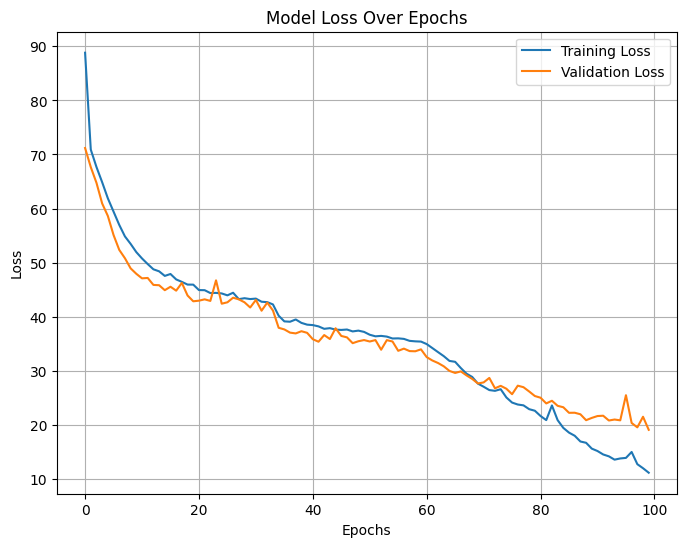

In [ ]:
import matplotlib.pyplot as plt



loss = history.history['loss']

val_loss = history.history['val_loss']



plt.figure(figsize=(8, 6))

plt.plot(loss, label='Training Loss')

plt.plot(val_loss, label='Validation Loss')

plt.title('Model Loss Over Epochs')

plt.xlabel('Epochs')

plt.ylabel('Loss')

plt.legend(loc='upper right')

plt.grid(True)

plt.show()


# Predection Part

In [ ]:
sample = load_data(tf.convert_to_tensor('/kaggle/input/grid-corpus-dataset-for-training-lipnet/data/s1_processed/bbal7s.mpg'))

In [ ]:
sample[0].shape

TensorShape([75, 46, 140, 1])

In [ ]:
sample[1]

<tf.Tensor: shape=(24,), dtype=int64, numpy=
array([ 2,  9, 14, 30,  2, 12, 21,  5, 30,  1, 20, 30, 12, 30, 19,  5, 22,
        5, 14, 30, 19, 15, 15, 14])>

In [ ]:
print('~'*100, 'REAL TEXT')

[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l seven soon'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')

[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue an s seven soon'>]